<a href="https://colab.research.google.com/github/tomik062/AI_Project/blob/main/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

extract data from github and merge together

In [14]:
import requests
import os
import importlib.util
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split,GridSearchCV, LeaveOneOut,KFold
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso,ElasticNet
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import math

# Define the GitHub details
def init_process():
  repo_owner = 'tomik062'
  repo_name = 'AI_Project'
  file_path = 'extract_data.py'
  url = f'https://raw.githubusercontent.com/{repo_owner}/{repo_name}/main/{file_path}'

  # Directory to save the downloaded file
  download_dir = 'data_extraction_code'
  if not os.path.exists(download_dir):
      os.makedirs(download_dir)

  local_file_path = os.path.join(download_dir, file_path)

  # Download the file
  response = requests.get(url)
  response.raise_for_status() # Raise an exception for bad status codes

  with open(local_file_path, 'wb') as f:
      f.write(response.content)

  print(f"Downloaded {file_path} to {local_file_path}")

  # Import the function from the downloaded file
  spec = importlib.util.spec_from_file_location("extract_data_module", local_file_path)
  module = importlib.util.module_from_spec(spec)
  spec.loader.exec_module(module)
  # Call the extract_data function and print the output
  return module.extract_data()

In [26]:
def calc_features_year(data,year):
    feature_map = {
        'urbanization': 0,
        'avg birth age': 1,
        'happiness index': 2,
        'health expenditure': 3,
        'physicians per capita': 4,
        'GNI PPP': 5,
        'female labor participation': 6,
        'christians (%)': 7,
        'muslims (%)': 8,
        'no religion (%)': 9,
        'buddhists (%)': 10,
        'hindus (%)': 11,
        'jews (%)': 12,
        'other religion (%)': 13,
        'in Asia-Pacific':14,
        'in Europe':15,
        'in Latin America-Caribbean':16,
        'in Middle East-North Africa':17,
        'in North America':18,
        'in Sub-Saharan Africa':19,
        'post-HS education men (%)': 20,
        'Post-HS education women (%)': 21,
        'human development index': 22,
        'gender inequality index': 23,
        'first marriage age women': 24,
        'first marriage age men': 25,
        'maternity leave index': 26,
        'work hours men': 27,
        'work hours women': 28,
        'abortion rate': 29,
        'social media users': 30
    }
    countries_with_data = sorted(list(set([key[0] for key in data.keys() if key[1] == year])))
    index = pd.MultiIndex.from_product([countries_with_data, [year]], names=['country', 'year'])
    df = pd.DataFrame(index=index, columns=feature_map.keys())
    target=[]
    # Populate the DataFrame
    for (country, yr) in index:
        key = (country, yr)
        features = data[key][1]
        target.append(data[key][0])
        for feature_name, feature_index in feature_map.items():
            if feature_index < len(features):
              df.loc[key, feature_name] = features[feature_index]
              if str(features[feature_index]) =='nan':
                df.loc[key, feature_name]=handle_missing_values(data,feature_index,country,year)
    return df,target



def handle_missing_values(data, feature_index, country, year):
    # try taking the value from the last 3 years
    for i in range(1, 4):
        past_year = year - i
        if (country, past_year) in data:
            past_data = data[(country, past_year)][1] # Access the list of features
            if feature_index < len(past_data) and str(past_data[feature_index])!='nan':
                return past_data[feature_index]

    # otherwise if missing last 3 years, linearly extrapulate from last decade
    recent_years_data = []
    for i in range(10,0,-1):
        past_year = year - i
        if (country, past_year) in data:
            past_data = data[(country, past_year)][1] # Access the list of features
            if feature_index < len(past_data) and not pd.isna(past_data[feature_index]):
                 recent_years_data.append((past_year, past_data[feature_index]))

    if len(recent_years_data) >= 2:
        years = [item[0] for item in recent_years_data]
        values = [item[1] for item in recent_years_data]
        last_value = values[-1]
        # Linear extrapolation using linear regression with polyfit
        try:
            m, c = np.polyfit(years, values, 1)
            extrapolated_value = m * year + c

            # Check if extrapolated value is within 50% of last value
            if last_value != 0 and abs(extrapolated_value - last_value) / abs(last_value) > 0.5:
                return last_value
            elif last_value == 0 and abs(extrapolated_value) > 0.5 * np.mean(values): # Handle edge case where last_value is 0
                 return last_value
            else:
                return extrapolated_value
        except np.linalg.LinAlgError:
            # Handle cases where polyfit fails (e.g., all years are the same)
            return last_value # Return the last known value
    elif len(recent_years_data) == 1:
         # If only one data point in the last 10 years, use that value
         return recent_years_data[0][1]

    # If still missing after checking last 10 years, return NaN
    return np.nan

In [16]:
def find_missing_features(df_features):

  # Identify countries with and without NaN values
  countries_with_nan = df_features[df_features.isnull().any(axis=1)].index.tolist()
  countries_without_nan = df_features.dropna().index.tolist()
  countries_with_one_nan = df_features[df_features.isnull().sum(axis=1) == 1].index.tolist()

  # Print the results
  print("Countries with NaN values in their features:")
  print(countries_with_nan)
  print("\nCountries without NaN values in their features:")
  print(countries_without_nan)
  print("\nCountries with exactly one NaN value in their features:")
  print(countries_with_one_nan)

  print(f"\nNumber of countries with NaN values: {len(countries_with_nan)}")
  print(f"Number of countries without NaN values: {len(countries_without_nan)}")
  print(f"Number of countries with exactly one NaN value: {len(countries_with_one_nan)}")

  # Group countries by their single missing feature
  missing_features_grouped = {}
  if countries_with_one_nan:
      for country in countries_with_one_nan:
          missing_feature_name = df_features.loc[country].isnull().idxmax()
          if missing_feature_name not in missing_features_grouped:
              missing_features_grouped[missing_feature_name] = []
          missing_features_grouped[missing_feature_name].append(str(country))

      # Print countries grouped by missing feature
      print("\nMissing feature for countries with exactly one NaN:")
      for feature, countries in missing_features_grouped.items():
          print(f"  Missing feature is '{feature}':")
          print(f"    Countries: {', '.join(countries)}")

process 2023 data:
add some missing data, split to train and test and normalize

In [17]:
def process_2023_data(data_output):
    df_features, target = calc_features_year(data_output, 2023)
    missing_values_to_fill = {
        'abortion rate': {
            'Cyprus': 7,'Ireland': 6.7,'Malaysia': 11,
            'Mauritania': 42,'Malta': 3,'Morocco': 25, 'Congo, Rep.': 39
        },
        'maternity leave index': {
            'Albania': 23.23,'Bosnia and Herzegovina': 52.14,
            'Kazakhstan': 18,'Georgia': 7.59,'Kyrgyz Republic': 18,
            'Moldova': 18,'Angola': 13,'Armenia': 20,
            'Azerbaijan': 18,'Malawi': 12.86,'Bhutan': 8,
            'Tanzania': 12,'Tajikistan': 20,'North Macedonia': 39,
            'Liberia': 12.86,'Suriname': 0,'Uzbekistan': 18
        },
        'gender inequality index':{
            'Central African Republic':0.682
        }
    }

    # Fill in missing values using the dictionary
    for feature, country_values in missing_values_to_fill.items():
        for country, value in country_values.items():
            if (country,2023) in df_features.index:
                df_features.loc[(country,2023), feature] = value

    # Convert all columns to numeric, coercing errors
    df_features = df_features.apply(pd.to_numeric, errors='coerce')

    # Create a DataFrame for the target variable
    y = pd.Series(target, index=df_features.index, name='target')

    # Combine features and target into a single DataFrame for easier NaN handling
    combined_df = pd.concat([df_features, y], axis=1)

    # Remove rows with NaN values
    combined_df_cleaned = combined_df.dropna()

    # Separate features and target again
    X = combined_df_cleaned.drop('target', axis=1)
    y = combined_df_cleaned['target']

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    return X_train, X_test, y_train, y_test

In [18]:
def plot_features(X_train):

  # Get the list of columns
  columns = X_train.columns

  # Calculate the number of rows needed
  n_cols = 5
  n_rows = math.ceil(len(columns) / n_cols)

  # Create subplots
  fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 5))
  axes = axes.flatten() # Flatten the 2D array of axes for easy iteration

  # Plot histograms for all features
  for i, column in enumerate(columns):
      axes[i].hist(X_train[column], bins=10)
      axes[i].set_title(f'Histogram of {column}')
      axes[i].set_xlabel(column)
      axes[i].set_ylabel('Frequency')
      axes[i].grid(True)

  # Hide any unused subplots
  for j in range(i + 1, len(axes)):
      fig.delaxes(axes[j])

  plt.tight_layout()
  plt.show()

In [19]:
class Scaling2023(BaseEstimator, TransformerMixin):
    def __init__(self,log_features=None,features_to_scale=None,health_features=None):
        self.log_features=log_features or ['no religion (%)','other religion (%)','buddhists (%)','hindus (%)','jews (%)','GNI PPP']
        self.health_features=health_features or ['physicians per capita','health expenditure']
        self.features_to_scale=features_to_scale or [
            'urbanization','avg birth age','happiness index','GNI PPP','female labor participation','christians (%)','muslims (%)','no religion (%)',
            'buddhists (%)','hindus (%)','jews (%)','other religion (%)','post-HS education men (%)','post-HS education men (%)',
            'human development index','gender inequality index','first marriage age women','first marriage age men','maternity leave index',
            'work hours men','work hours women','abortion rate','social media users','healthcare index score'
        ]
        self.health_scaler=StandardScaler()
        self.scaler=StandardScaler()

    def fit(self,X,y=None):
        X_copy=X.copy()
        missing=[c for c in (self.health_features+self.log_features) if c not in X_copy.columns]
        if missing: raise KeyError(f"Missing columns: {missing}")

        self.health_scaler.fit(X_copy[self.health_features])
        h_scaled=self.health_scaler.transform(X_copy[self.health_features])
        score=h_scaled[:,0]+h_scaled[:,1]
        X_copy=X_copy.drop(columns=self.health_features)
        X_copy['healthcare index score']=score
        for f in self.log_features:
            X_copy[f]=pd.to_numeric(X_copy[f])
            X_copy[f]=np.log1p(X_copy[f])
        self.scaler.fit(X_copy[self.features_to_scale])
        return self

    def transform(self,X):
        X_copy=X.copy()
        h_scaled=self.health_scaler.transform(X_copy[self.health_features])
        score=h_scaled[:,0]+h_scaled[:,1]
        X_copy=X_copy.drop(columns=self.health_features)
        X_copy['healthcare index score']=score
        for f in self.log_features:
            X_copy[f]=pd.to_numeric(X_copy[f])
            X_copy[f]=np.log1p(X_copy[f])
        X_copy[self.features_to_scale]=self.scaler.transform(X_copy[self.features_to_scale])
        return X_copy

In [20]:
def create_health_index_score(X_train,X_test):
    scaler_healthcare = StandardScaler()
    health_features = ['physicians per capita','health expenditure']
    X_train[health_features] = scaler_healthcare.fit_transform(X_train[health_features])
    X_test[health_features] = scaler_healthcare.transform(X_test[health_features])
    X_train['healthcare index score'] = X_train['physicians per capita'] + X_train['health expenditure']
    X_test['healthcare index score'] = X_test['physicians per capita'] + X_test['health expenditure']
    X_train = X_train.drop(['physicians per capita', 'health expenditure'], axis=1)
    X_test = X_test.drop(['physicians per capita', 'health expenditure'], axis=1)
    return X_train,X_test

In [21]:
def feature_correlations(df, method):
    """Calculates and visualizes correlation matrix, and prints top 5 correlated pairs."""

    correlation_matrix = df.corr(method=method)

    plt.figure(figsize=(18, 15))
    sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt=".2f")
    plt.title(f'{method.capitalize()} Correlation Heatmap of Features in X_train')
    plt.show()

    print(f"\nTop 5 most highly correlated pairs of features (absolute {method.capitalize()} correlation):")
    upper_tri = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
    stacked_corr = upper_tri.stack().sort_values(ascending=False, key=abs)
    top_5_correlated_pairs = stacked_corr.head(5)

    if top_5_correlated_pairs.empty:
        print("No correlated pairs found.")
    else:
        for (feature1, feature2), correlation in top_5_correlated_pairs.items():
            print(f"  {feature1} and {feature2}: {correlation:.4f}")


In [9]:
def analyze_target_correlation(X, y, method_name):
    combined_data = pd.concat([X, y], axis=1)
    correlation_series = combined_data.corr(method=method_name)['target'].drop('target').sort_values(ascending=False)

    plt.figure(figsize=(12, 8))
    sns.barplot(x=correlation_series.values, y=correlation_series.index, palette='coolwarm')
    plt.title(f'{method_name} Correlation of Features with Target Variable')
    plt.xlabel(f'{method_name} Correlation Coefficient')
    plt.ylabel('Features')
    plt.show()

    print(f"\n{method_name} Correlation with Target:")
    print(correlation_series)


In [10]:
def analyze_mutual_information(X, y):
    """Calculates and displays Mutual Information scores of features with the target."""
    mi_scores = mutual_info_regression(X, y)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)

    print("Mutual Information Scores of Features with Target Variable:")
    print(mi_scores)
    plt.figure(figsize=(10, 6))
    sns.barplot(x=mi_scores.values, y=mi_scores.index, palette='viridis')
    plt.title('Mutual Information Scores of Features with Target Variable')
    plt.xlabel('Mutual Information Score')
    plt.ylabel('Features')
    plt.tight_layout()
    plt.show()

In [11]:
def gridsearch_loocv_lasso(X,y):
    pipe=Pipeline([('scaling2023',Scaling2023()),('lasso',Lasso())])
    param_grid={'lasso__alpha':[val*(10**i) for i in range(-12,4) for val in [1,2,5]]}
    gs=GridSearchCV(pipe,param_grid,cv=LeaveOneOut(),scoring='neg_mean_squared_error',n_jobs=-1)
    gs.fit(X,y)
    return gs

def gridsearch_elastic_net_loocv(X,y):
    pipe=Pipeline([('scaling2023',Scaling2023()),('elastic',ElasticNet())])
    param_grid={
        'elastic__alpha':[val*(10**i) for i in range(-6,2) for val in [1,2,5]],
        'elastic__l1_ratio':[0.1,0.3,0.5,0.7,0.9,0.95,0.99,0.995,1.0]
    }
    gs=GridSearchCV(pipe,param_grid,cv=LeaveOneOut(),scoring='neg_mean_squared_error',n_jobs=-1)
    gs.fit(X,y)
    return gs

def gridsearch_random_forest(X,y):
  pipe=Pipeline([('scaling2023',Scaling2023()),('rf',RandomForestRegressor(random_state=42,n_jobs=-1))])
  kf=KFold(n_splits=5,shuffle=True,random_state=42)
  param_grid = {
        'rf__n_estimators': [100, 200, 400],
        'rf__max_depth': [None, 3, 4, 5],
        'rf__min_samples_split': [2, 3 , 5, 9],
        'rf__min_samples_leaf': [1, 2, 4, 6],
        'rf__max_features': ['sqrt', 0.5, 1.0],
    }
  gs=GridSearchCV(pipe,param_grid,cv=kf,scoring='neg_mean_squared_error',n_jobs=-1)
  gs.fit(X,y)
  return gs


def gridsearch_xgboost(X, y):
    pipe = Pipeline([
        ('scaling2023', Scaling2023()),
        ('xgb', XGBRegressor(tree_method='hist',random_state=42,n_jobs=-1,importance_type='gain'))])
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    param_grid = {
        'xgb__n_estimators': [40, 100, 300, 600],
        'xgb__learning_rate': [0.003, 0.01 , 0.03, 0.1, 0.3],
        'xgb__max_depth': [2, 3, 5 , 8],
        'xgb__min_child_weight': [1, 3 , 5],
        'xgb__subsample': [0.5, 0.8, 1.0],
        'xgb__colsample_bytree': [0.5, 0.8, 1.0],
        'xgb__gamma': [0, 1],
    }
    gs=GridSearchCV(pipe,param_grid,cv=kf,scoring='neg_mean_squared_error',n_jobs=-1)
    gs.fit(X,y)
    return gs

import pandas as pd

def report_grid_search(gs,X,model):
  best_est = gs.best_estimator_
  names = best_est.named_steps['scaling2023'].transform(X).columns
  idx = gs.best_index_
  cv_mse = -gs.cv_results_['mean_test_score'][idx]
  print(f"Best params: {gs.best_params_}")
  print(f"CV MSE: {cv_mse:.4f} (±{gs.cv_results_['std_test_score'][idx]:.4f})")
  est = best_est.named_steps[model]

  if model in ['lasso','elastic']:
    coefs = pd.Series(est.coef_, index=names)
    coefs = coefs.reindex(coefs.abs().sort_values(ascending=False).index)
    print("\ncoefficients:")
    for f,c in coefs.items():
      print(f"{f}: {c:.4f}")
  else:#random forrest or xgboost
    if model=='rf':
      print("\nmean decrease in imputirty by feature:")
    if model=='xgb':
      print("\nmean gain by feature:")
    imp = pd.Series(est.feature_importances_, index=names).sort_values(ascending=False)
    for f,v in imp.items():
      print(f"{f}: {v:.4f}")


Downloaded extract_data.py to data_extraction_code/extract_data.py
Downloaded GNI_PPP_const_2021_dollars.csv to data/GNI_PPP_const_2021_dollars.csv
Downloaded Religious-Composition-percentages.csv to data/Religious-Composition-percentages.csv
Downloaded abortion-rates-by-country-2025.csv to data/abortion-rates-by-country-2025.csv
Downloaded age-at-first-marriage-by-country-2025.csv to data/age-at-first-marriage-by-country-2025.csv
Downloaded average-workweek-by-country-2025.csv to data/average-workweek-by-country-2025.csv
Downloaded female-labor-force-participation-rates-slopes.csv to data/female-labor-force-participation-rates-slopes.csv
Downloaded female-labor-participation.csv to data/female-labor-participation.csv
Downloaded gender-inequality-index.xlsx to data/gender-inequality-index.xlsx
Downloaded happiness-cantril-ladder.csv to data/happiness-cantril-ladder.csv
Downloaded healthcare-expenditure-per-capita-ppp.csv to data/healthcare-expenditure-per-capita-ppp.csv
Downloaded high

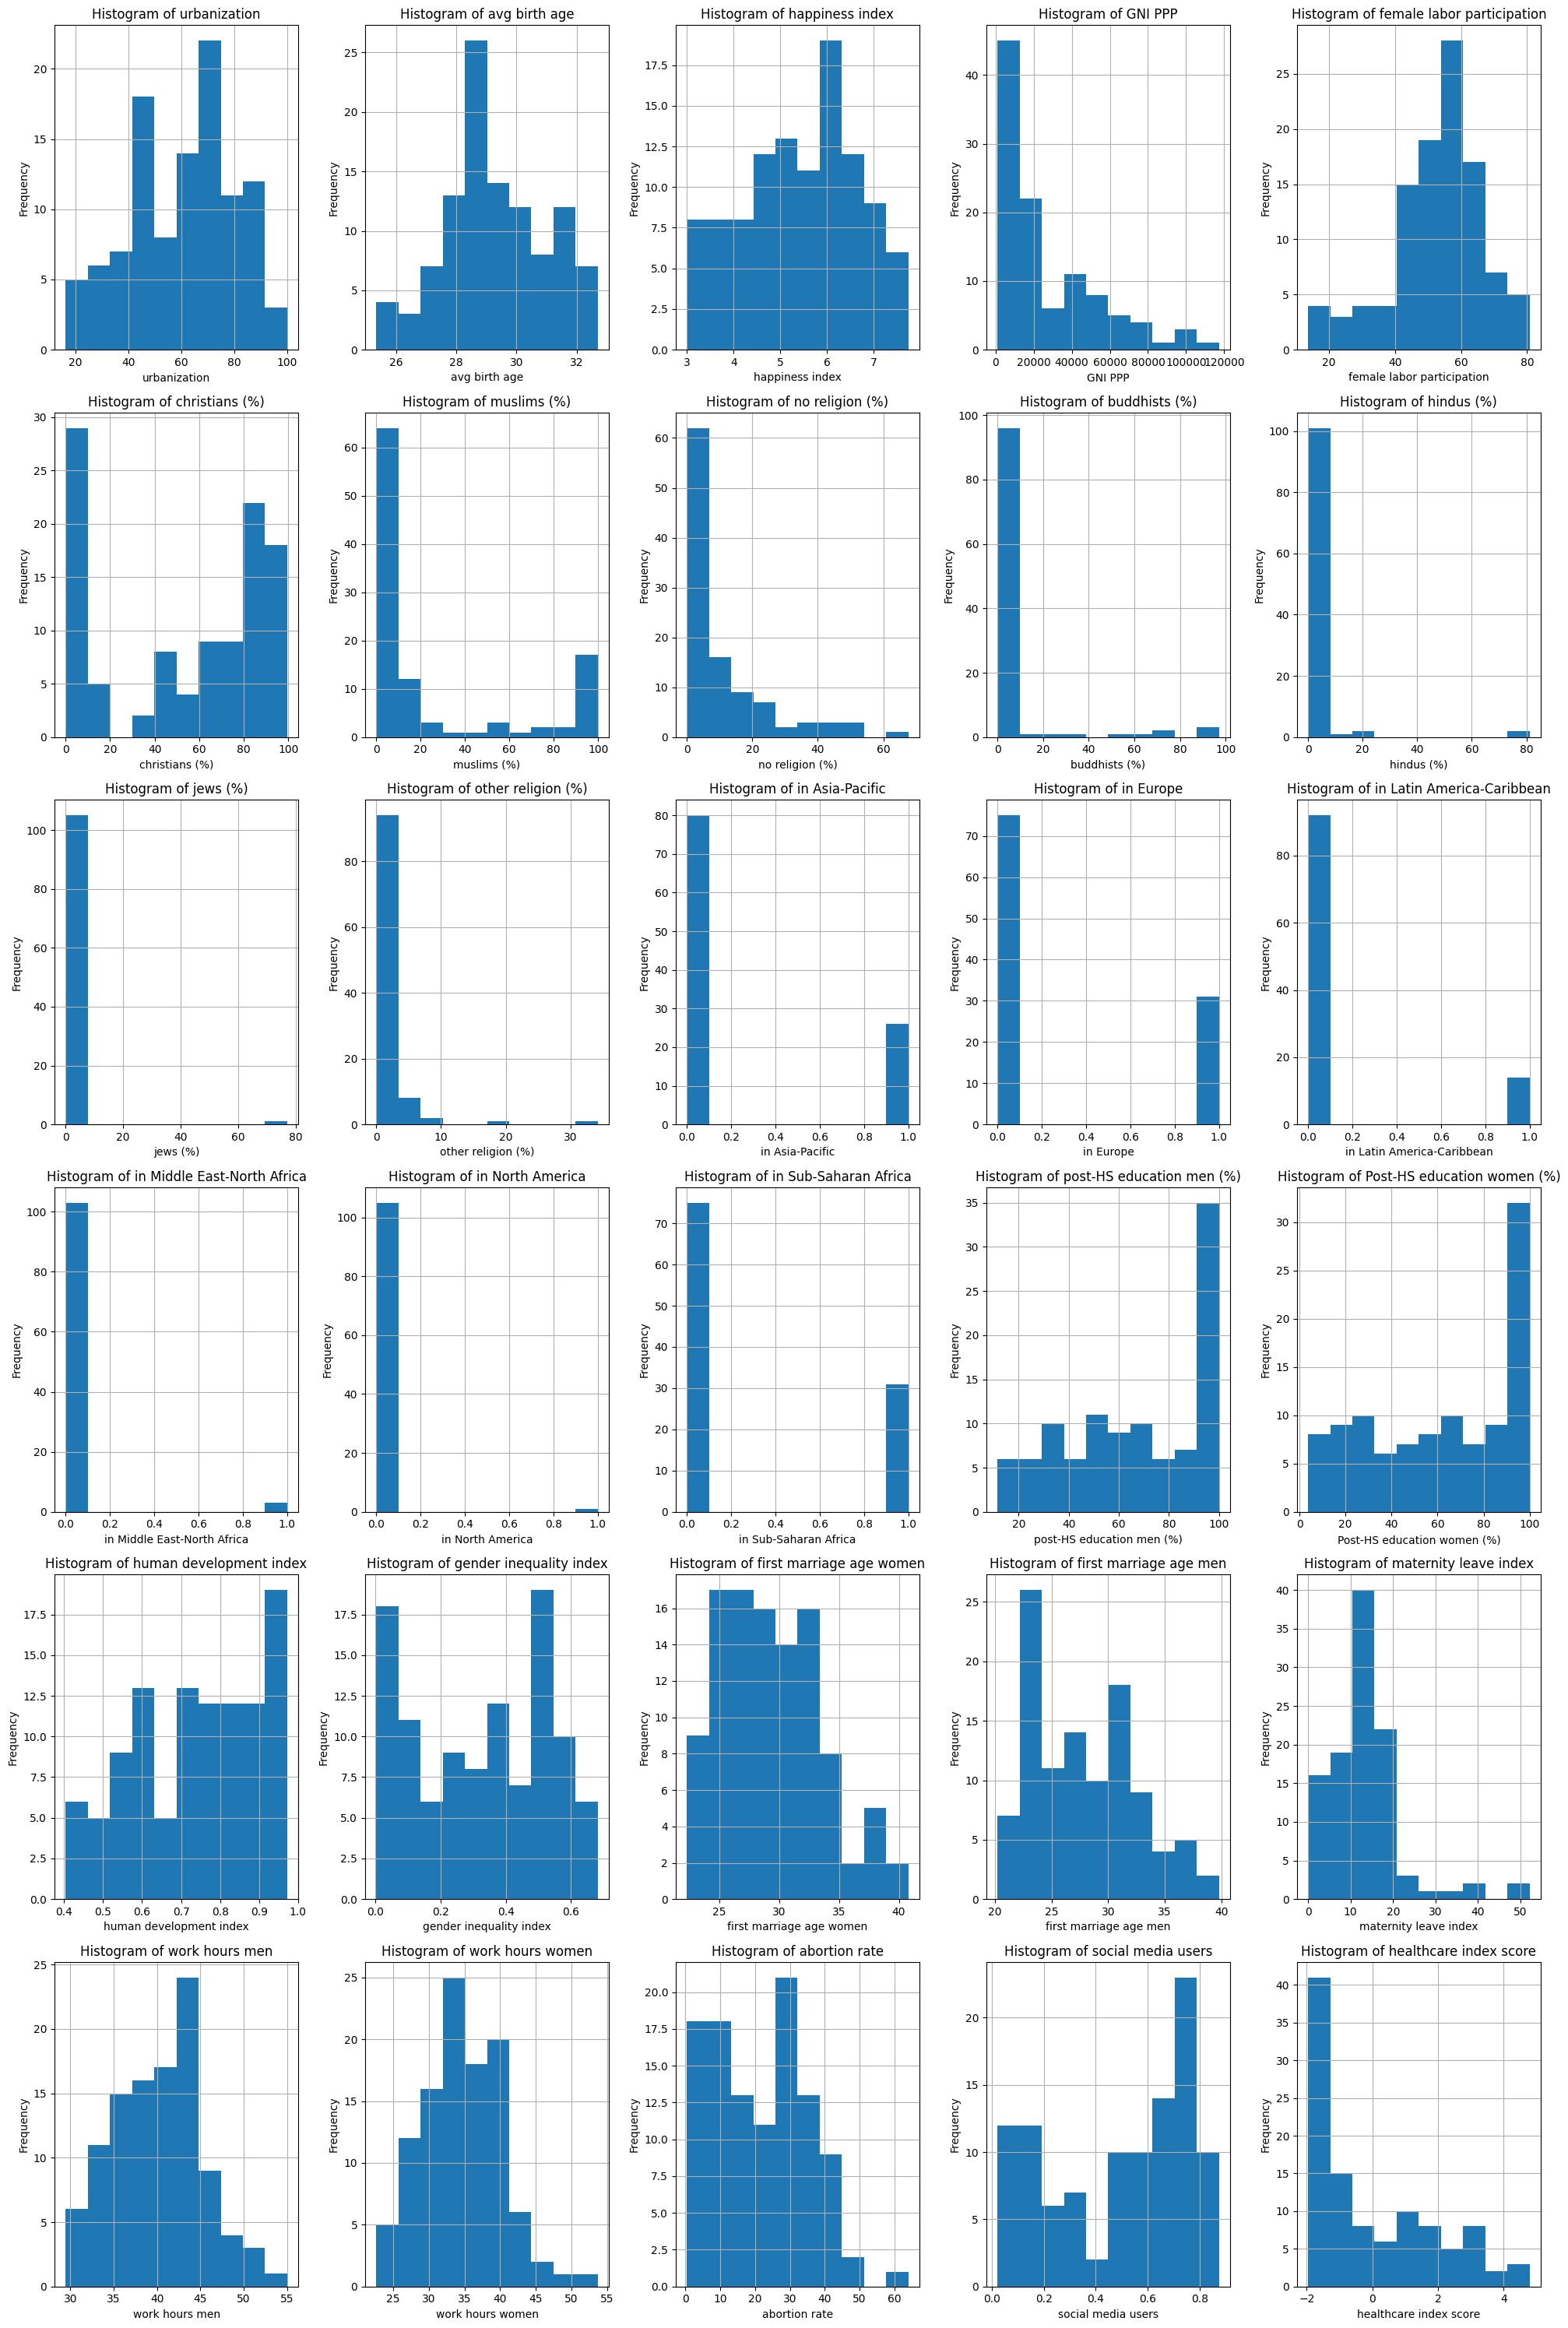

scaled features


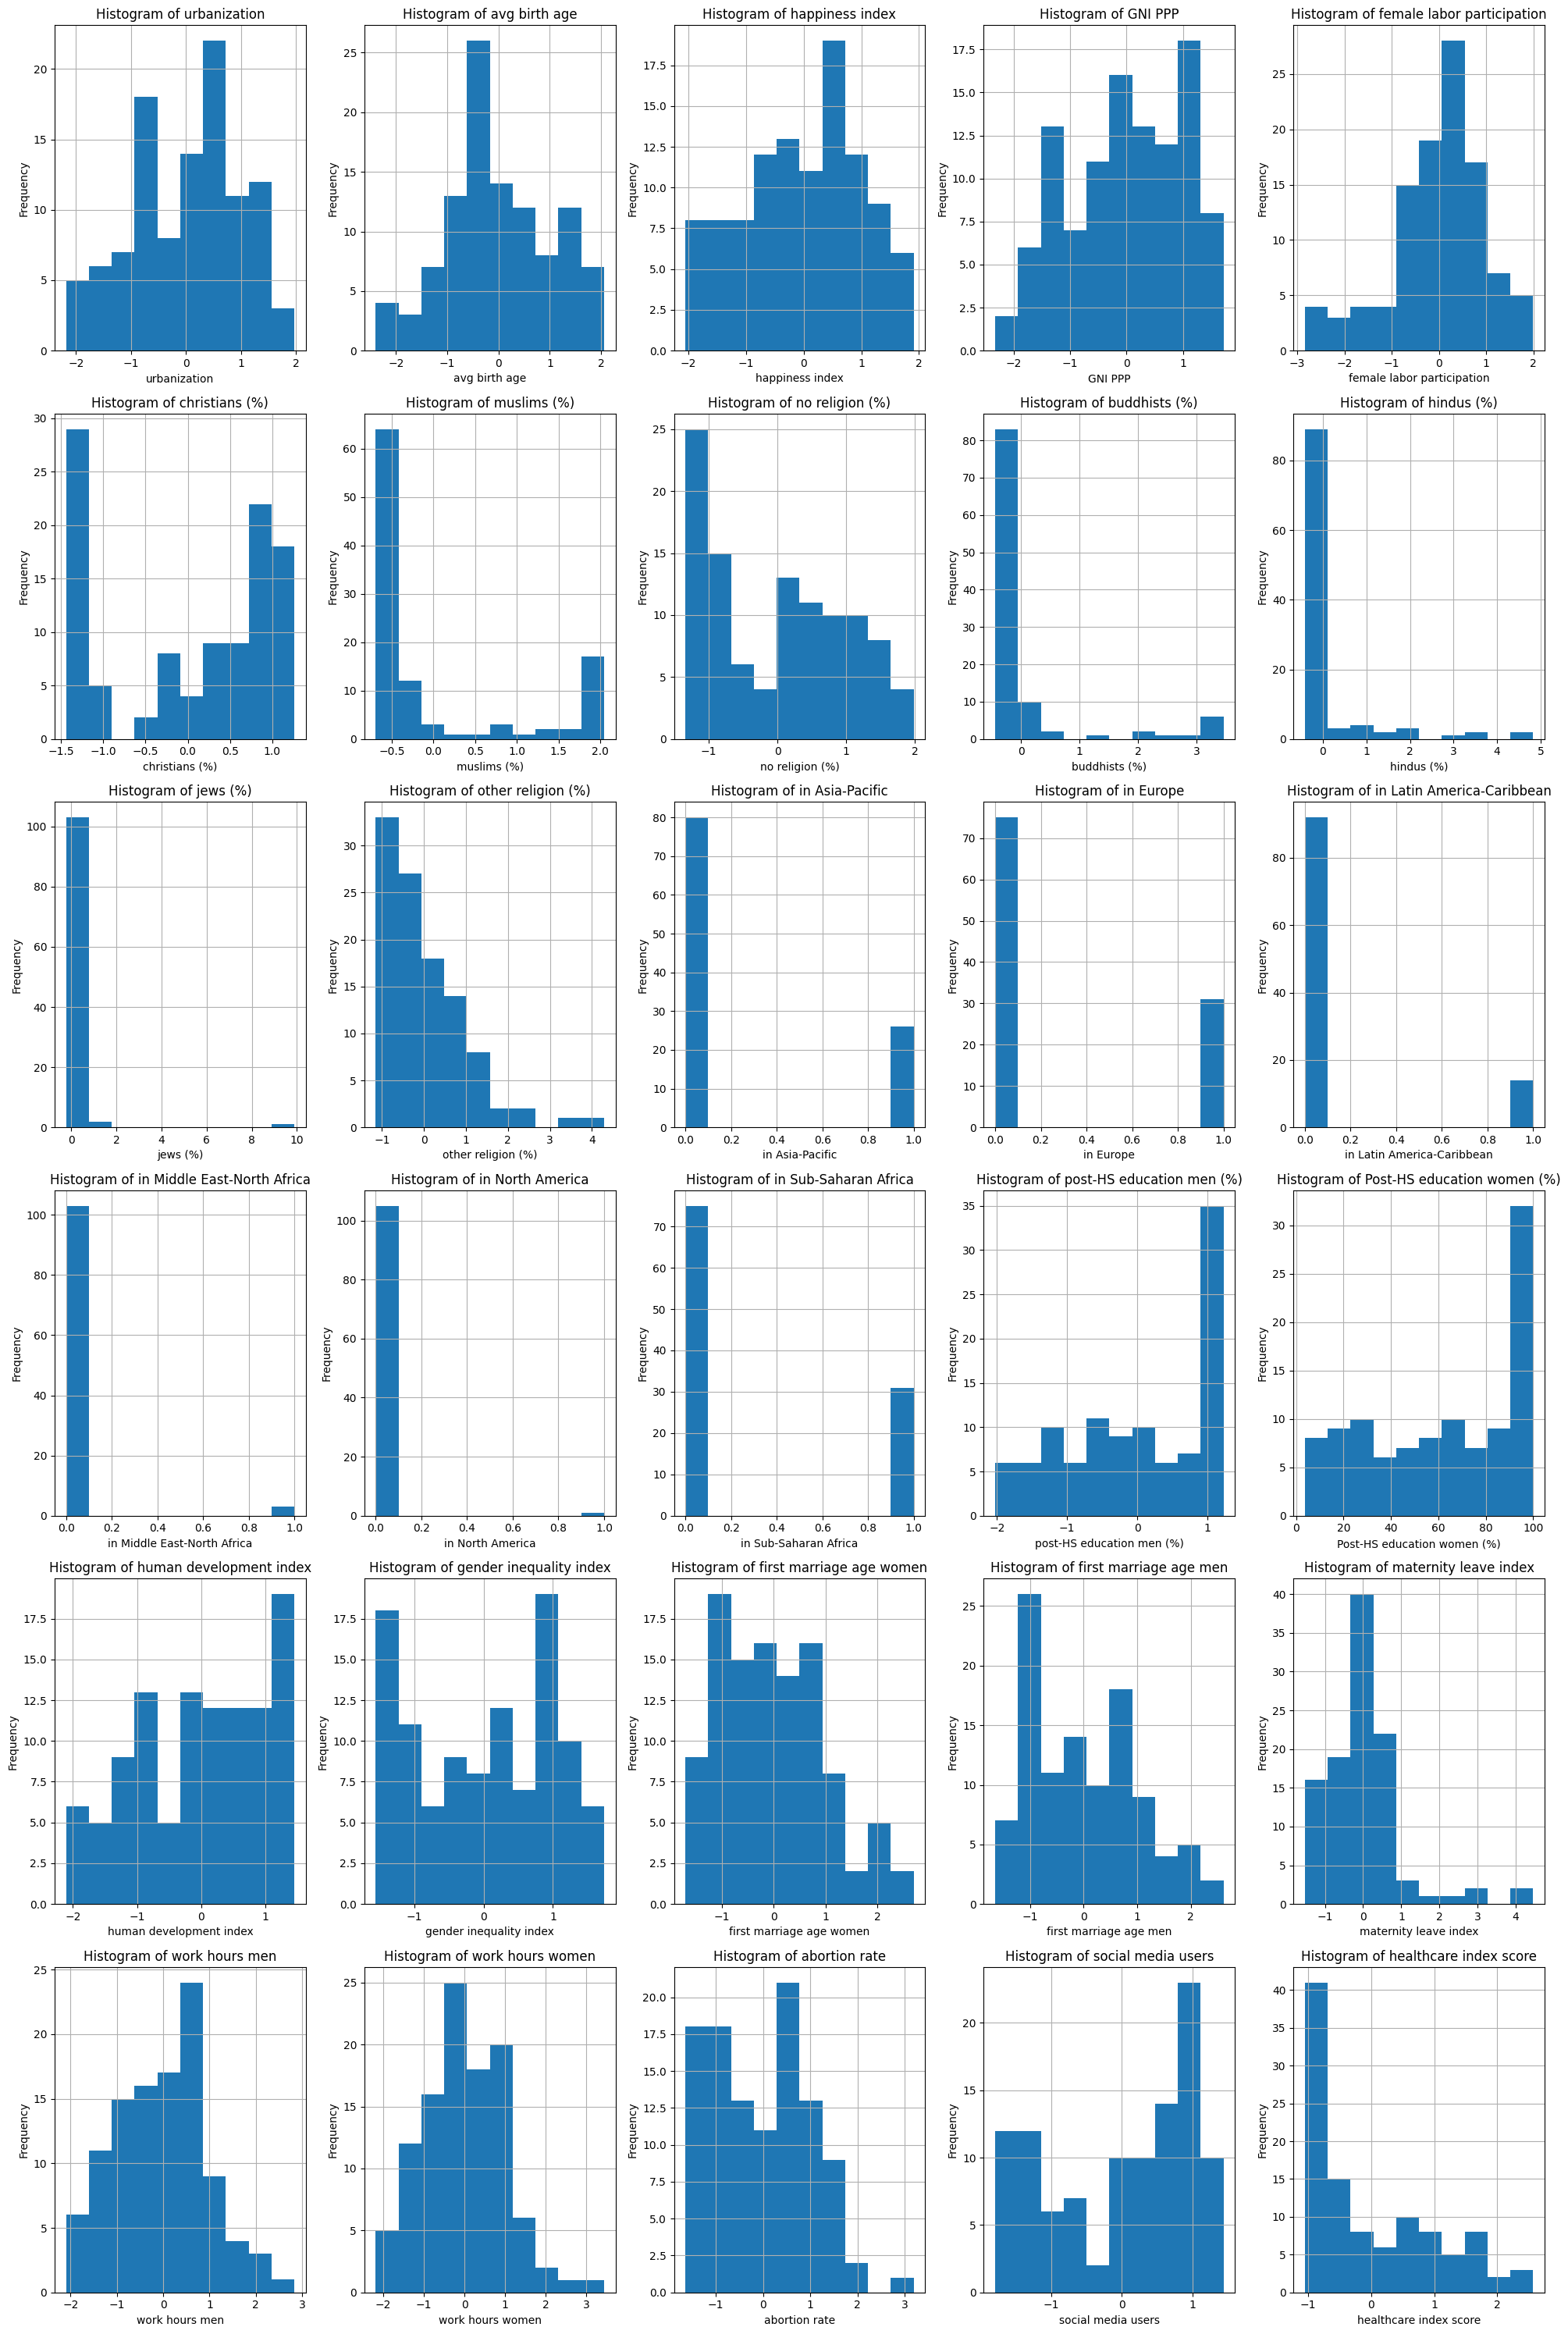

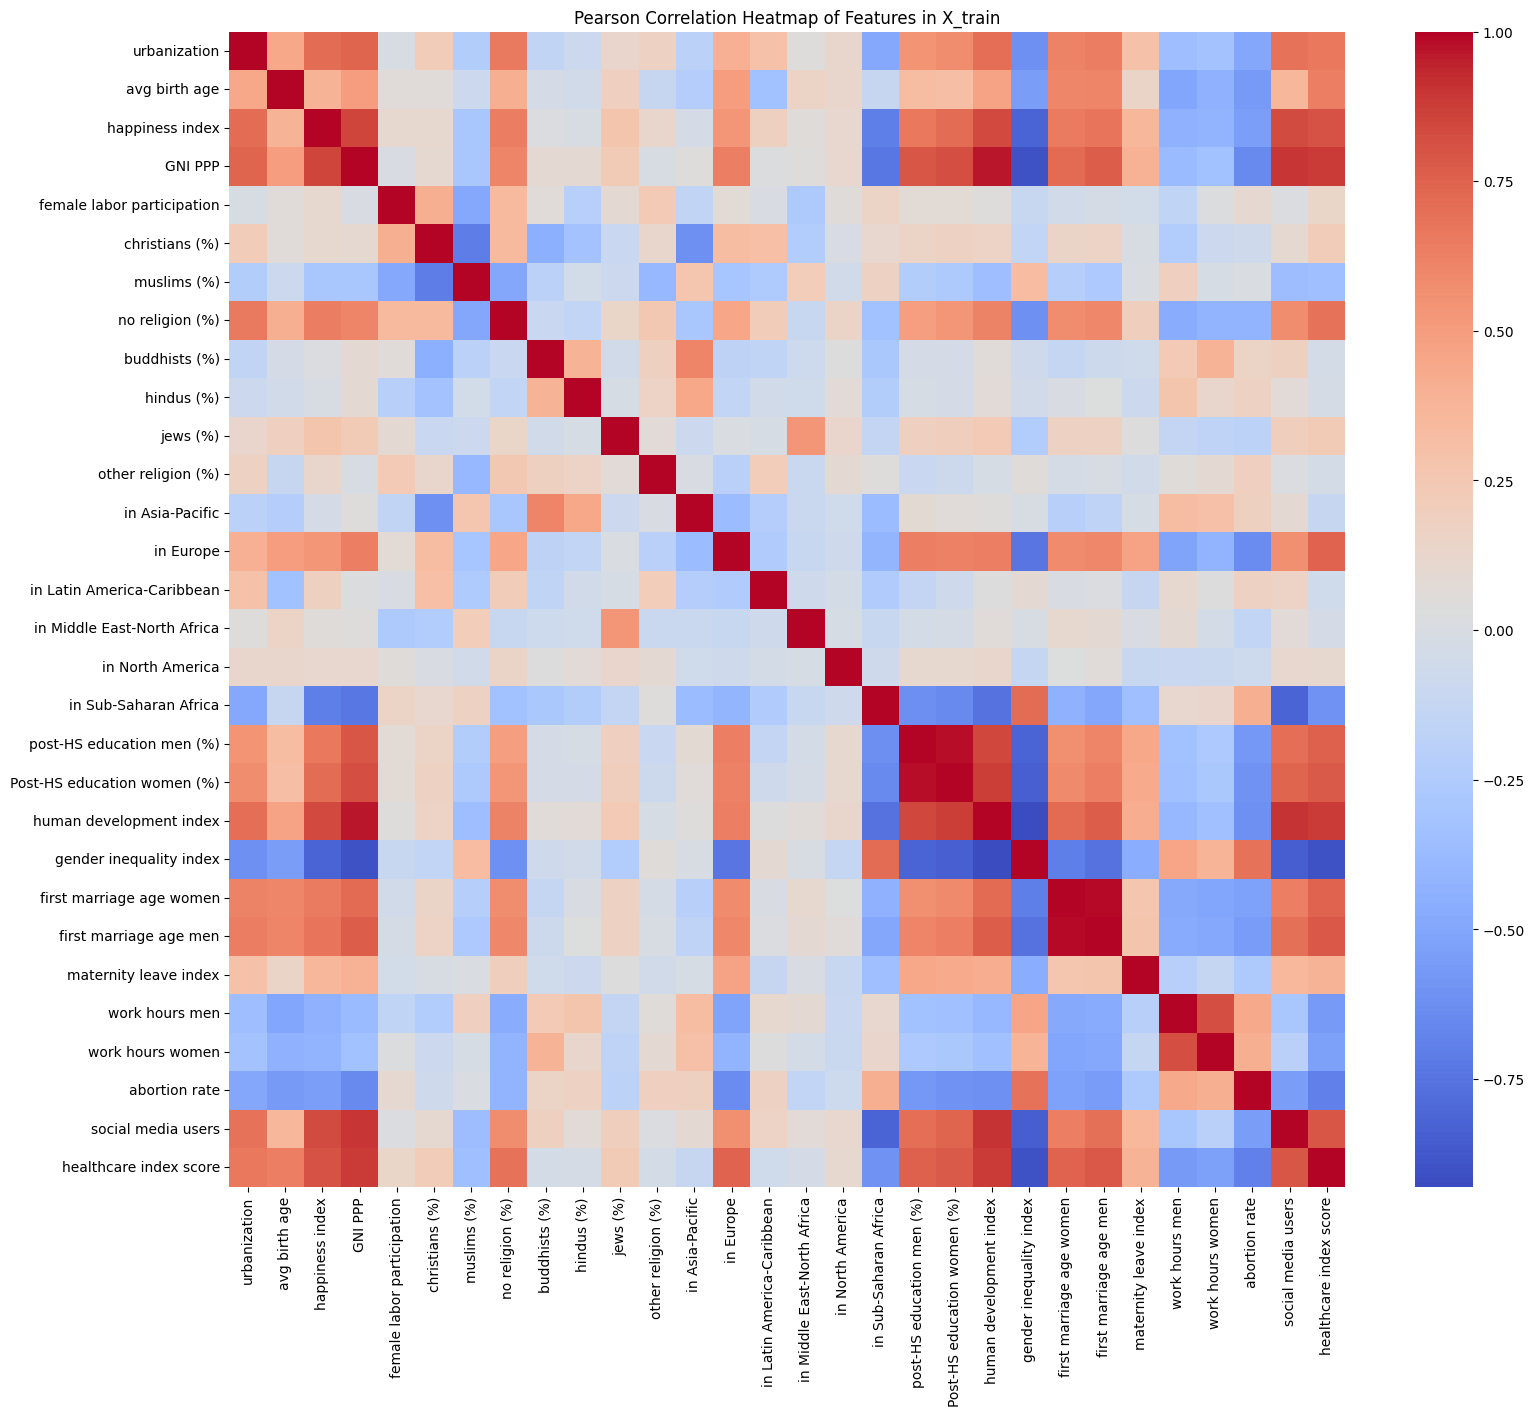


Top 5 most highly correlated pairs of features (absolute Pearson correlation):
  first marriage age women and first marriage age men: 0.9895
  post-HS education men (%) and Post-HS education women (%): 0.9805
  GNI PPP and human development index: 0.9682
  human development index and gender inequality index: -0.9295
  gender inequality index and healthcare index score: -0.9060


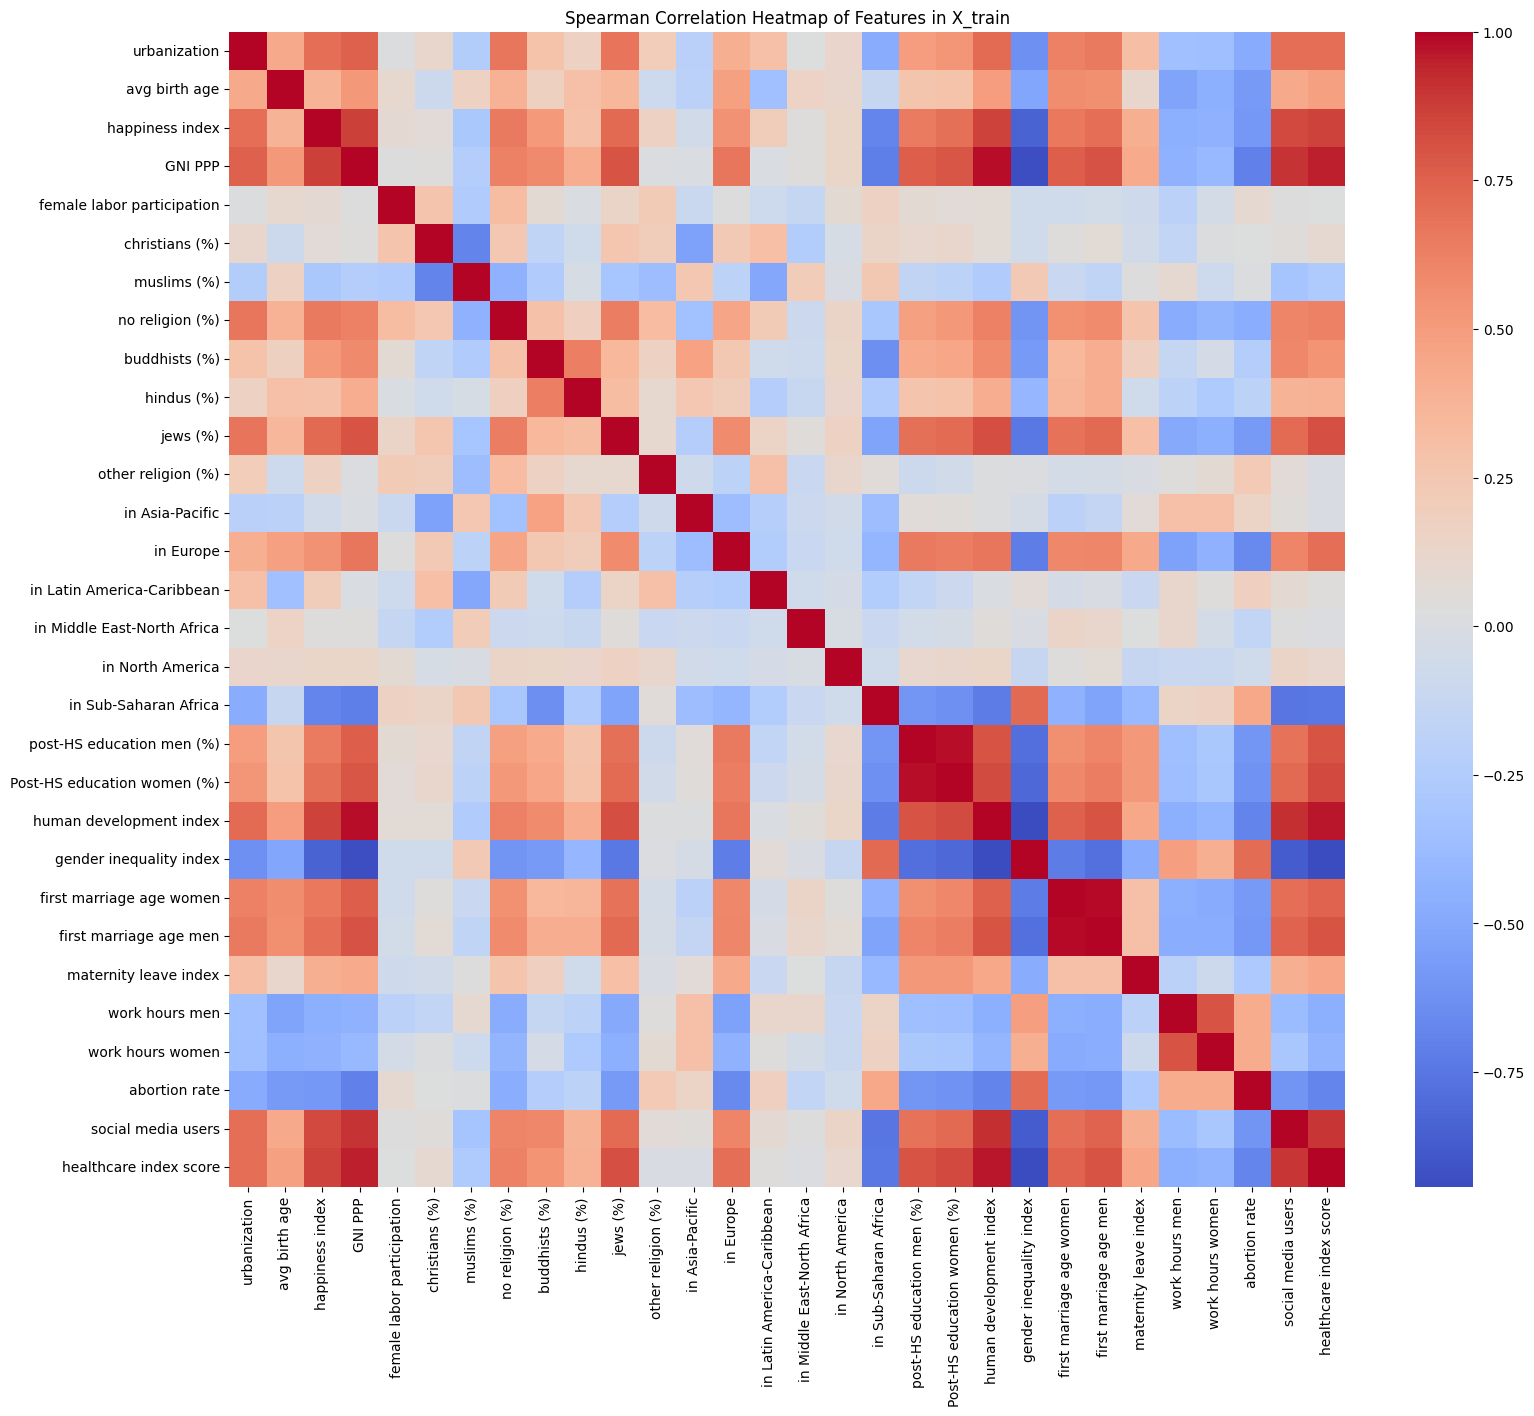


Top 5 most highly correlated pairs of features (absolute Spearman correlation):
  first marriage age women and first marriage age men: 0.9871
  post-HS education men (%) and Post-HS education women (%): 0.9820
  GNI PPP and human development index: 0.9781
  human development index and healthcare index score: 0.9629
  GNI PPP and healthcare index score: 0.9517


/tmp/ipython-input-1140664916.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlation_series.values, y=correlation_series.index, palette='coolwarm')


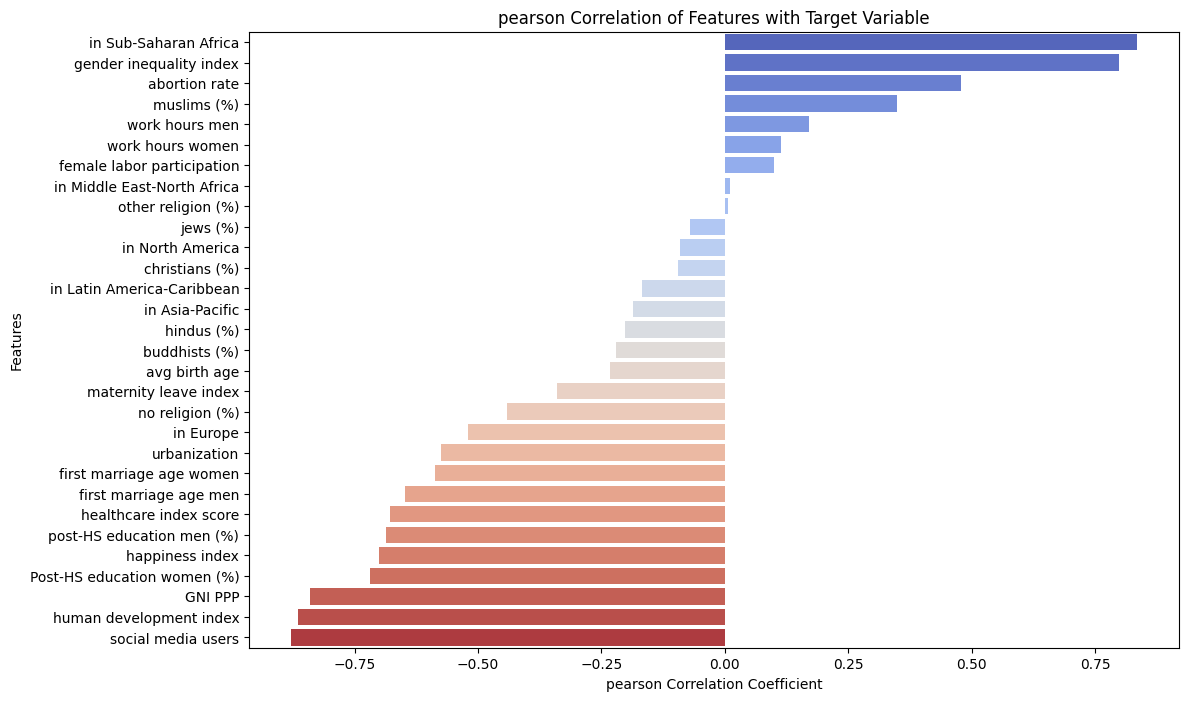


pearson Correlation with Target:
in Sub-Saharan Africa          0.834381
gender inequality index        0.797438
abortion rate                  0.478885
muslims (%)                    0.349747
work hours men                 0.170845
work hours women               0.114112
female labor participation     0.099885
in Middle East-North Africa    0.011170
other religion (%)             0.005654
jews (%)                      -0.071159
in North America              -0.090590
christians (%)                -0.094503
in Latin America-Caribbean    -0.167194
in Asia-Pacific               -0.185259
hindus (%)                    -0.202353
buddhists (%)                 -0.220292
avg birth age                 -0.232213
maternity leave index         -0.339560
no religion (%)               -0.440683
in Europe                     -0.519533
urbanization                  -0.575595
first marriage age women      -0.586678
first marriage age men        -0.647425
healthcare index score        -0.678775
post-H

/tmp/ipython-input-1140664916.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlation_series.values, y=correlation_series.index, palette='coolwarm')


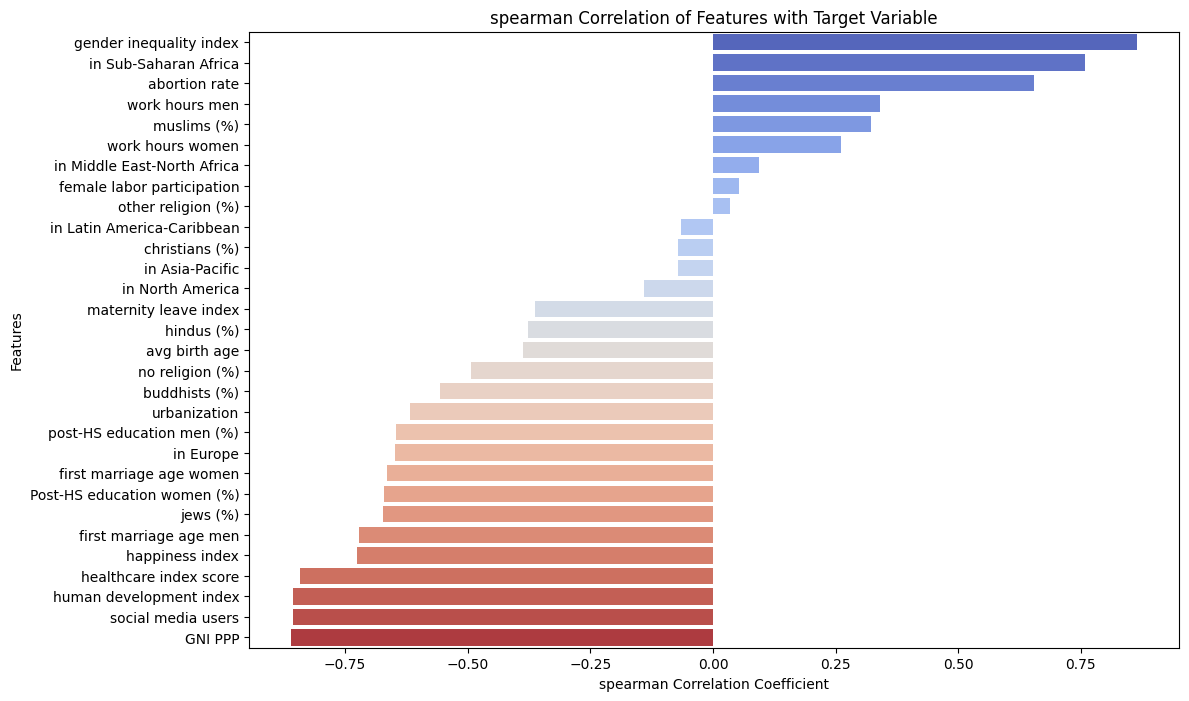


spearman Correlation with Target:
gender inequality index        0.863911
in Sub-Saharan Africa          0.758841
abortion rate                  0.654204
work hours men                 0.341201
muslims (%)                    0.322241
work hours women               0.260881
in Middle East-North Africa    0.093897
female labor participation     0.053731
other religion (%)             0.035053
in Latin America-Caribbean    -0.066026
christians (%)                -0.070489
in Asia-Pacific               -0.070590
in North America              -0.140345
maternity leave index         -0.362375
hindus (%)                    -0.376686
avg birth age                 -0.387128
no religion (%)               -0.494177
buddhists (%)                 -0.556041
urbanization                  -0.616775
post-HS education men (%)     -0.646761
in Europe                     -0.647336
first marriage age women      -0.663912
Post-HS education women (%)   -0.669942
jews (%)                      -0.672670
first

/tmp/ipython-input-2867624879.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=mi_scores.values, y=mi_scores.index, palette='viridis')


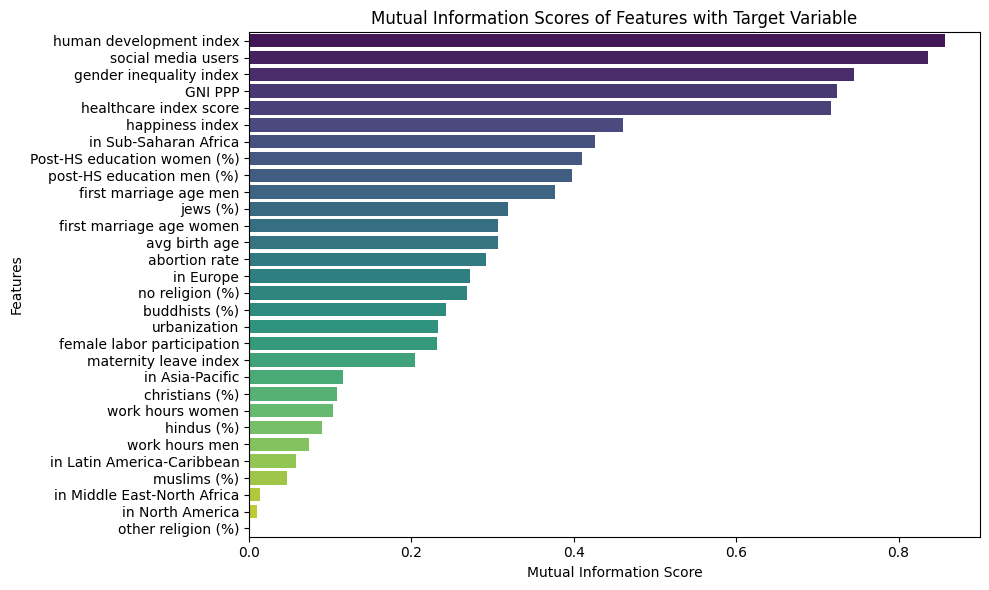


lasso regressor:
Best params: {'lasso__alpha': 0.02}
CV MSE: 0.3480 (±0.7681)

coefficients:
human development index: -0.5994
in Sub-Saharan Africa: 0.3986
social media users: -0.3733
gender inequality index: 0.1861
avg birth age: 0.1592
female labor participation: 0.1509
muslims (%): 0.1156
jews (%): 0.1134
first marriage age men: -0.1120
work hours women: -0.1042
hindus (%): -0.0547
healthcare index score: 0.0339
buddhists (%): -0.0319
no religion (%): 0.0311
other religion (%): 0.0055
maternity leave index: 0.0035
Post-HS education women (%): 0.0011
in Asia-Pacific: -0.0000
urbanization: 0.0000
happiness index: 0.0000
GNI PPP: -0.0000
christians (%): -0.0000
in Europe: -0.0000
in Latin America-Caribbean: -0.0000
in Middle East-North Africa: 0.0000
in North America: -0.0000
post-HS education men (%): 0.0000
first marriage age women: -0.0000
work hours men: -0.0000
abortion rate: 0.0000

elastic net regressor:


KeyboardInterrupt: 

In [27]:
## 2023 data##
X_train, X_test, y_train, y_test = process_2023_data(init_process())

#feature distrebutions
unscaled_X_train,unscaled_X_test = create_health_index_score(X_train.copy(),X_test.copy())
print('unscaled features')
plot_features(unscaled_X_train)

scaler = Scaling2023()
scaler.fit(X_train)
scaled_train = scaler.transform(X_train)
scaled_test = scaler.transform(X_test)

print('scaled features')
plot_features(scaled_train)

#feature pairs correlations
feature_correlations(scaled_train, 'pearson')
feature_correlations(scaled_train, 'spearman')
#feature-target correlations and mutual information
analyze_target_correlation(scaled_train, y_train, 'pearson')
analyze_target_correlation(scaled_train, y_train, 'spearman')
analyze_mutual_information(scaled_train, y_train)
#linear regressor models
print('\nlasso regressor:')
lasso_gs = gridsearch_loocv_lasso(X_train,y_train)
report_grid_search(lasso_gs,X_train,'lasso')
print('\nelastic net regressor:')
elastic_net_gs = gridsearch_elastic_net_loocv(X_train,y_train)
report_grid_search(elastic_net_gs,X_train,'elastic')
#random forest regressor model
print('\nrandom forest regressor:')
rf_gs = gridsearch_random_forest(X_train,y_train)
report_grid_search(rf_gs,X_train,'rf')
#xgboost regressor model
print('\nxgboost regressor:')
xgb_gs = gridsearch_xgboost(X_train,y_train)
report_grid_search(xgb_gs,X_train,'xgb')

In [ ]:
print(X_train.select_dtypes(include='object').columns.tolist())
print('++++')
print(X_train[['in Asia-Pacific', 'in Europe', 'in Latin America-Caribbean',
         'in Middle East-North Africa', 'in North America', 'in Sub-Saharan Africa']].dtypes)


['urbanization', 'avg birth age', 'happiness', 'health expenditure', 'physicians per capita', 'GNI PPP', 'female labor participation', 'christians', 'muslims', 'no religion', 'buddhists', 'hindus', 'jews', 'other religion', 'in Asia-Pacific', 'in Europe', 'in Latin America-Caribbean', 'in Middle East-North Africa', 'in North America', 'in Sub-Saharan Africa', 'education man', 'education women', 'hdi', 'gii', 'avg marriage age women', 'avg marriage age men', 'maternity leave index', 'work hours men', 'work hours women', 'abortions', 'social media users']
++++
in Asia-Pacific                object
in Europe                      object
in Latin America-Caribbean     object
in Middle East-North Africa    object
in North America               object
in Sub-Saharan Africa          object
dtype: object


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

# Assuming grid_search_rf, X_train, y_train, X_test, and y_test are already defined

# Get the best trained Random Forest model
best_rf_model = rf_gs.best_estimator_

# --- Evaluate on Training Set ---
y_train_pred_rf = best_rf_model.predict(X_train)
mse_train_rf = mean_squared_error(y_train, y_train_pred_rf)
r2_train_rf = r2_score(y_train, y_train_pred_rf)

print(f"Training Set Performance:")
print(f"  Mean Squared Error: {mse_train_rf:.4f}")
print(f"  R-squared: {r2_train_rf:.4f}")

print("\n" + "="*50 + "\n")

# --- Evaluate on Test Set ---
y_test_pred_rf = best_rf_model.predict(X_test)
mse_test_rf = mean_squared_error(y_test, y_test_pred_rf)
r2_test_rf = r2_score(y_test, y_test_pred_rf)

print(f"Test Set Performance:")
print(f"  Mean Squared Error: {mse_test_rf:.4f}")
print(f"  R-squared: {r2_test_rf:.4f}")

print("\n" + "="*50 + "\n")

# --- Validation Set Performance (from Grid Search) ---
# The best_score_ from GridSearchCV is the mean cross-validation score (negative MSE)
validation_neg_mse = rf_gs.best_score_
validation_mse = -validation_neg_mse # Convert negative MSE to positive MSE

print(f"Validation Set Performance (from Grid Search):")
print(f"  Mean Cross-Validation MSE: {validation_mse:.4f}")
# Note: R-squared is not directly available from best_score_ if MSE was the scoring metric
# You could calculate R-squared on the validation folds separately if needed.

Training Set Performance:
  Mean Squared Error: 0.0740
  R-squared: 0.9602


Test Set Performance:
  Mean Squared Error: 0.1473
  R-squared: 0.8882


Validation Set Performance (from Grid Search):
  Mean Cross-Validation MSE: 0.3397


Downloaded extract_data.py to data_extraction_code/extract_data.py
Downloaded GNI_PPP_const_2021_dollars.csv to data/GNI_PPP_const_2021_dollars.csv
Downloaded Religious-Composition-percentages.csv to data/Religious-Composition-percentages.csv
Downloaded abortion-rates-by-country-2025.csv to data/abortion-rates-by-country-2025.csv
Downloaded age-at-first-marriage-by-country-2025.csv to data/age-at-first-marriage-by-country-2025.csv
Downloaded average-workweek-by-country-2025.csv to data/average-workweek-by-country-2025.csv
Downloaded female-labor-force-participation-rates-slopes.csv to data/female-labor-force-participation-rates-slopes.csv
Downloaded female-labor-participation.csv to data/female-labor-participation.csv
Downloaded gender-inequality-index.xlsx to data/gender-inequality-index.xlsx
Downloaded happiness-cantril-ladder.csv to data/happiness-cantril-ladder.csv
Downloaded healthcare-expenditure-per-capita-ppp.csv to data/healthcare-expenditure-per-capita-ppp.csv
Downloaded high

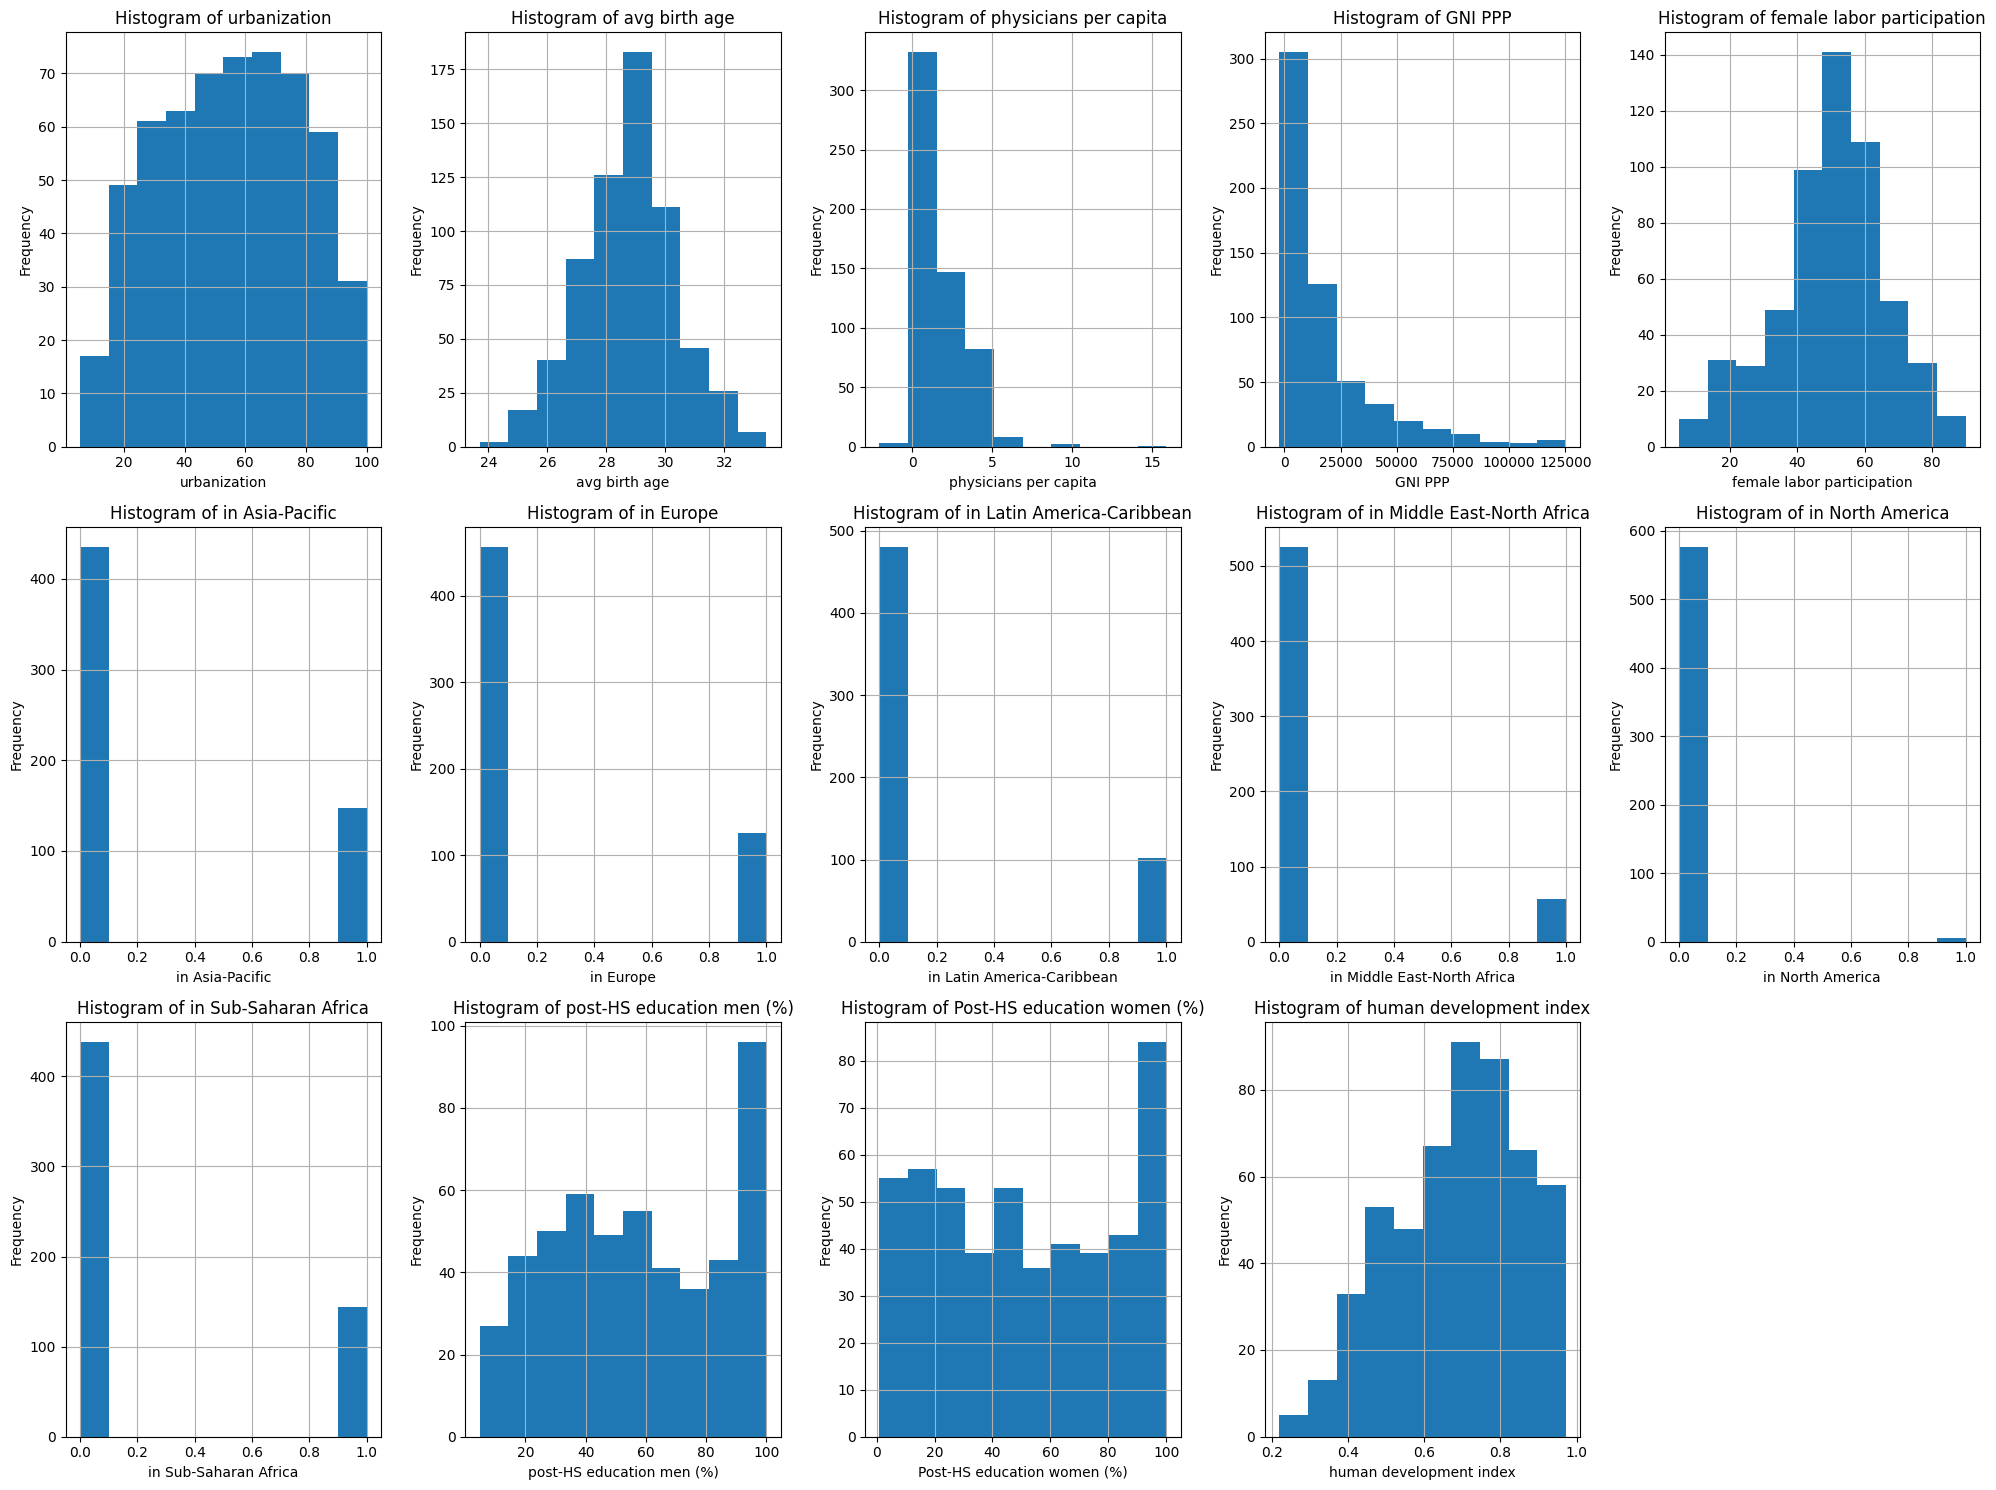

/usr/local/lib/python3.12/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


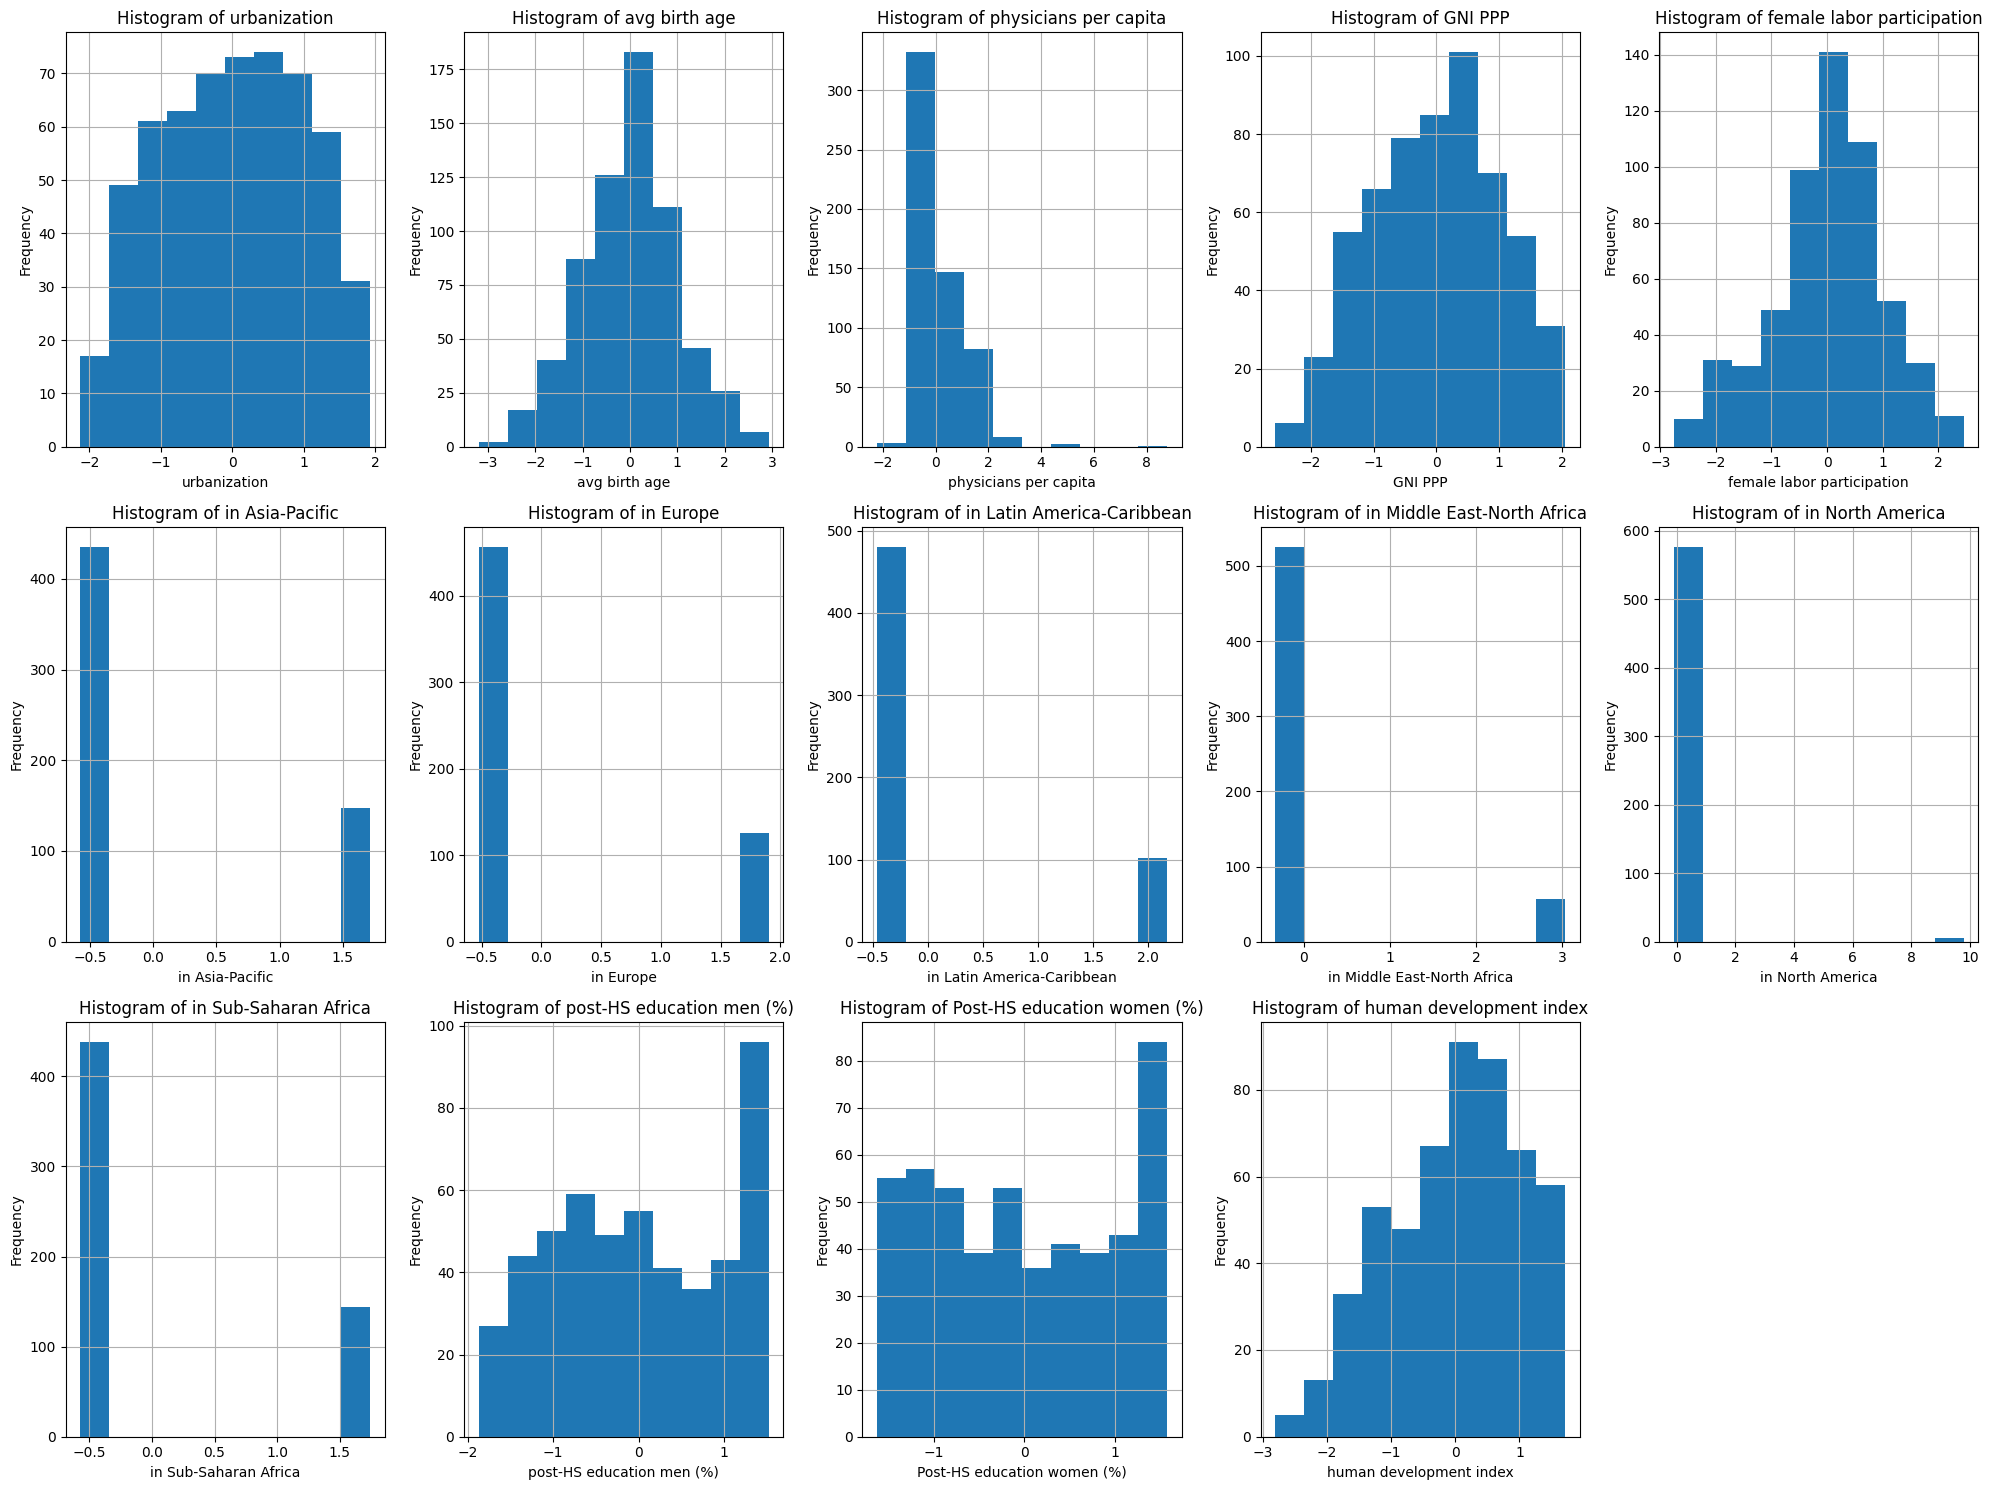

Combined Features DataFrame:


urbanization  avg birth age  \
country                        year                                
Afghanistan                    2023     29.149118         30.366   
Albania                        2023     61.257164         29.132   
Algeria                        2023     71.819740         31.453   
American Samoa                 2023     95.064800         29.375   
Andorra                        2023     95.002630         32.518   
Angola                         2023     66.940850         28.589   
Antigua and Barbuda            2023     37.252800         28.255   
Argentina                      2023     94.484090         29.073   
Armenia                        2023     70.108630         27.781   
Aruba                          2023     49.899000         28.824   
Australia                      2023     91.178000         31.391   
Austria                        2023     71.841030         31.167   
Azerbaijan                     2023     60.199720         25.930   
Bahamas, The                   2023     86.610504         28.841   
Bahrain                        2023     22.618103         29.980   
Bangladesh                     2023     36.122910         26.041   
Barbados                       2023     53.105800         27.733   
Belarus                        2023     79.138240         28.653   
Belgium                        2023     97.748985         31.006   
Belize                         2023     58.516197         27.182   
Benin                          2023     50.171100         29.079   
Bermuda                        2023           NaN         32.103   
Bhutan                         2023     44.672700         29.890   
Bolivia                        2023     71.371340         28.144   
Bosnia and Herzegovina         2023     56.159560         29.037   
Botswana                       2023     68.341980         28.672   
Brazil                         2023     89.161610         27.813   
British Virgin Islands         2023           NaN         28.479   
Brunei Darussalam              2023     80.233600         30.652   
Bulgaria                       2023     76.173360         27.948   
Burkina Faso                   2023     35.304660         29.189   
Burundi                        2023     16.265913         30.160   
Cabo Verde                     2023     68.970310         28.637   
Cambodia                       2023     25.638426         27.896   
Cameroon                       2023     66.530270         28.417   
Canada                         2023     84.673240         31.413   
Cayman Islands                 2023           NaN         30.646   
Central African Republic       2023     46.615730         28.968   
Chad                           2023     35.728035         29.239   
Channel Islands                2023           NaN            NaN   
Chile                          2023     91.913890         31.193   
China                          2023     56.526077         29.018   
Colombia                       2023     80.266495         26.554   
Comoros                        2023     32.547802         30.217   
Congo, Dem. Rep.               2023     43.397125         30.073   
Congo, Rep.                    2023     68.785110         28.562   
Costa Rica                     2023     70.387360         28.201   
Cote d'Ivoire                  2023     58.631890         29.028   
Croatia                        2023     65.204330         30.660   
Cuba                           2023     79.985016         26.216   
Curacao                        2023           NaN         29.970   
Cyprus                         2023     61.511757         31.700   
Czechia                        2023     78.326680         30.430   
Denmark                        2023     89.299730         31.638   
Djibouti                       2023     83.079260         31.522   
Dominica                       2023     70.824480         28.208   
Dominican Republic             2023     74.478710         27.433   
Ecuador                  


Combined Target Series:


country                         year
Afghanistan                     2023    4.8400
Albania                         2023    1.3480
Algeria                         2023    2.7660
American Samoa                  2023    2.2860
Andorra                         2023    1.0820
Angola                          2023    5.1240
Antigua and Barbuda             2023    1.5780
Argentina                       2023    1.5000
Armenia                         2023    1.9000
Aruba                           2023    1.6020
Australia                       2023    1.5000
Austria                         2023    1.3200
Azerbaijan                      2023    1.5500
Bahamas, The                    2023    1.3730
Bahrain                         2023    1.8240
Bangladesh                      2023    2.1630
Barbados                        2023    1.7080
Belarus                         2023    1.2080
Belgium                         2023    1.4700
Belize                          2023    2.0070
Benin                           2023    4.5560
Bermuda                         2023    1.4010
Bhutan                          2023    1.4620
Bolivia                         2023    2.5470
Bosnia and Herzegovina          2023    1.4860
Botswana                        2023    2.7320
Brazil                          2023    1.6190
British Virgin Islands          2023    1.0450
Brunei Darussalam               2023    1.7470
Bulgaria                        2023    1.8100
Burkina Faso                    2023    4.1860
Burundi                         2023    4.8780
Cabo Verde                      2023    1.5220
Cambodia                        2023    2.5790
Cameroon                        2023    4.3220
Canada                          2023    1.2600
Cayman Islands                  2023    1.5310
Central African Republic        2023    6.0120
Chad                            2023    6.1200
Channel Islands                 2023    1.3700
Chile                           2023    1.1670
China                           2023    0.9990
Colombia                        2023    1.6450
Comoros                         2023    3.8780
Congo, Dem. Rep.                2023    6.0510
Congo, Rep.                     2023    4.1570
Costa Rica                      2023    1.3300
Cote d'Ivoire                   2023    4.2830
Croatia                         2023    1.4600
Cuba                            2023    1.4390
Curacao                         2023    1.2000
Cyprus                          2023    1.3890
Czechia                         2023    1.4500
Denmark                         2023    1.5000
Djibouti                        2023    2.6090
Dominica                        2023    1.4840
Dominican Republic              2023    2.2430
Ecuador                         2023    1.8230
Egypt, Arab Rep.                2023    2.7500
El Salvador                     2023    1.7750
Equatorial Guinea               2023    4.0810
Eritrea                         2023    3.7130
Estonia                         2023    1.3100
Eswatini                        2023    2.7530
Ethiopia                        2023    3.9890
Faroe Islands                   2023    1.8586
Fiji                            2023    2.2810
Finland                         2023    1.2600
France                          2023    1.6600
French Polynesia                2023    1.5010
Gabon                           2023    3.6470
Gambia, The                     2023    4.0060
Georgia                         2023    1.8100
Germany                         2023    1.3900
Ghana                           2023    3.3970
Gibraltar                       2023    1.8880
Greece                          2023    1.3200
Greenland                       2023    1.7690
Grenada                         2023    1.4870
Guam                            2023    2.7810
Guatemala                       2023    2.3110
Guinea                          2023    4.2170
Guinea-Bissau                   2023    3.8360
Guyana                          2023    2.4120
Haiti          


Transformed and Scaled Features DataFrame:


urbanization  avg birth age  \
country                        year                                
Afghanistan                    2023     -1.115601       1.000871   
Albania                        2023      0.263932       0.222967   
Algeria                        2023      0.717757       1.686107   
American Samoa                 2023      1.716489       0.376152   
Andorra                        2023      1.713818       2.357475   
Angola                         2023      0.508134      -0.119336   
Antigua and Barbuda            2023     -0.767423      -0.329887   
Argentina                      2023      1.691539       0.185774   
Armenia                        2023      0.644239      -0.628692   
Aruba                          2023     -0.224075       0.028806   
Australia                      2023      1.549491       1.647023   
Austria                        2023      0.718672       1.505815   
Azerbaijan                     2023      0.218499      -1.795548   
Bahamas, The                   2023      1.353247       0.039523   
Bahrain                        2023     -1.396208       0.757540   
Bangladesh                     2023     -0.815970      -1.725575   
Barbados                       2023     -0.086294      -0.658951   
Belarus                        2023      1.032199      -0.078991   
Belgium                        2023      1.831816       1.404322   
Belize                         2023      0.146166      -1.006297   
Benin                          2023     -0.212384       0.189556   
Bermuda                        2023           NaN       2.095862   
Bhutan                         2023     -0.448625       0.700804   
Bolivia                        2023      0.698491      -0.399860   
Bosnia and Herzegovina         2023      0.044912       0.163080   
Botswana                       2023      0.568334      -0.067013   
Brazil                         2023      1.462857      -0.608520   
British Virgin Islands         2023           NaN      -0.188679   
Brunei Darussalam              2023      1.079262       1.181163   
Bulgaria                       2023      0.904812      -0.523417   
Burkina Faso                   2023     -0.851126       0.258900   
Burundi                        2023     -1.669132       0.871010   
Cabo Verde                     2023      0.595330      -0.089077   
Cambodia                       2023     -1.266439      -0.556197   
Cameroon                       2023      0.490493      -0.227763   
Canada                         2023      1.270012       1.660892   
Cayman Islands                 2023           NaN       1.177381   
Central African Republic       2023     -0.365142       0.119583   
Chad                           2023     -0.832935       0.290419   
Channel Islands                2023           NaN            NaN   
Chile                          2023      1.581109       1.522205   
China                          2023      0.060660       0.151103   
Colombia                       2023      1.080675      -1.402183   
Comoros                        2023     -0.969575       0.906943   
Congo, Dem. Rep.               2023     -0.503430       0.816166   
Congo, Rep.                    2023      0.587373      -0.136356   
Costa Rica                     2023      0.656214      -0.363928   
Cote d'Ivoire                  2023      0.151137       0.157406   
Croatia                        2023      0.433524       1.186206   
Cuba                           2023      1.068581      -1.615256   
Curacao                        2023           NaN       0.751236   
Cyprus                         2023      0.274871       1.841814   
Czechia                        2023      0.997330       1.041216   
Denmark                        2023      1.468791       1.802730   
Djibouti                       2023      1.201526       1.729604   
Dominica                       2023      0.674995      -0.359515   
Dominican Republic             2023      0.832001      -0.848069   
Ecuador                  

In [9]:
data = init_process()
years = [2023, 2007, 1991]
all_features = []
all_targets = []

for year in years:
    df_features, target = calc_features_year(data, year)
    all_features.append(df_features)
    all_targets.extend(target)

combined_df_features = pd.concat(all_features)
combined_target = pd.Series(all_targets, index=combined_df_features.index, name='target')

columns_to_drop = [
    'christians (%)', 'muslims (%)', 'no religion (%)', 'buddhists (%)',
    'hindus (%)', 'jews (%)', 'other religion (%)', 'gender inequality index',
    'happiness index', 'first marriage age women', 'first marriage age men',
    'work hours men', 'work hours women', 'social media users', 'abortion rate',
    'health expenditure' ,'maternity leave index'
]

combined_df_features = combined_df_features.drop(columns=columns_to_drop)

# Convert all columns to numeric, coercing errors
combined_df_features = combined_df_features.apply(pd.to_numeric, errors='coerce')
plot_features(combined_df_features)

# Create a copy for transformation and scaling
combined_df_features_scaled = combined_df_features.copy()

# Log transform GNI PPP, handling potential zero or negative values
combined_df_features_scaled['GNI PPP'] = np.log1p(combined_df_features_scaled['GNI PPP'])

# Z-scale all features
scaler = StandardScaler()
combined_df_features_scaled = pd.DataFrame(scaler.fit_transform(combined_df_features_scaled), columns=combined_df_features_scaled.columns, index=combined_df_features_scaled.index)

# Plot histograms of the scaled features
plot_features(combined_df_features_scaled)

# Set pandas options to display all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

print("Combined Features DataFrame:")
display(combined_df_features)
print("\nCombined Target Series:")
display(combined_target)
print("\nTransformed and Scaled Features DataFrame:")
display(combined_df_features_scaled)


# Reset pandas options to default
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')

In [1]:
class ScalingMultiYear(BaseEstimator, TransformerMixin):
    def __init__(self,log_features=None,features_to_scale=None,health_features=None):
        self.log_features=log_features or ['GNI PPP']
        self.features_to_scale=features_to_scale or [
            'urbanization','avg birth age','GNI PPP',
            'female labor participation','post-HS education men (%)',
            'post-HS education men (%)','human development index',
            'physicians per capita'
        ]
        self.health_scaler=StandardScaler()
        self.scaler=StandardScaler()

    def fit(self,X,y=None):
        X_copy=X.copy()
        self.scaler.fit(X_copy[self.features_to_scale])
        return self

    def transform(self,X):
        X_copy=X.copy()
        for f in self.log_features:
            X_copy[f]=pd.to_numeric(X_copy[f])
            X_copy[f]=np.log1p(X_copy[f])
        X_copy[self.features_to_scale]=self.scaler.transform(X_copy[self.features_to_scale])
        return X_copy

NameError: name 'BaseEstimator' is not defined

In [10]:
# Filter for countries with unscaled GNI PPP less than 0
countries_with_low_gni = combined_df_features[combined_df_features['GNI PPP'] < 0]

# Print the countries and their GNI PPP values
print("Countries with unscaled GNI PPP smaller than 0:")
display(countries_with_low_gni[['GNI PPP']])

Countries with unscaled GNI PPP smaller than 0:


GNI PPP
country     year             
South Sudan 2023 -2266.666667

In [9]:
find_missing_features(combined_df_features)

Countries with NaN values in their features:
[('American Samoa', 2023), ('Andorra', 2023), ('Antigua and Barbuda', 2023), ('Aruba', 2023), ('Bermuda', 2023), ('British Virgin Islands', 2023), ('Cayman Islands', 2023), ('Channel Islands', 2023), ('Cuba', 2023), ('Curacao', 2023), ('Dominica', 2023), ('Equatorial Guinea', 2023), ('Eritrea', 2023), ('Faroe Islands', 2023), ('French Polynesia', 2023), ('Gibraltar', 2023), ('Greenland', 2023), ('Grenada', 2023), ('Guam', 2023), ('Hong Kong SAR, China', 2023), ('Isle of Man', 2023), ('Kiribati', 2023), ("Korea, Dem. People's Rep.", 2023), ('Kosovo', 2023), ('Liechtenstein', 2023), ('Macao SAR, China', 2023), ('Maldives', 2023), ('Marshall Islands', 2023), ('Micronesia, Fed. Sts.', 2023), ('Monaco', 2023), ('Montenegro', 2023), ('Nauru', 2023), ('New Caledonia', 2023), ('Northern Mariana Islands', 2023), ('Palau', 2023), ('Puerto Rico (US)', 2023), ('San Marino', 2023), ('Serbia', 2023), ('Seychelles', 2023), ('Sint Maarten (Dutch part)', 202

In [52]:

print(process_2023_data(init_process()))
"""
countries = sorted(list(set([key[0] for key in data.keys()])))
index=[(country, 2023) for country in countries]
for key in index:
  print(key in data)
"""

Downloaded extract_data.py to data_extraction_code/extract_data.py
Downloaded GNI_PPP_const_2021_dollars.csv to data/GNI_PPP_const_2021_dollars.csv
Downloaded Religious-Composition-percentages.csv to data/Religious-Composition-percentages.csv
Downloaded abortion-rates-by-country-2025.csv to data/abortion-rates-by-country-2025.csv
Downloaded age-at-first-marriage-by-country-2025.csv to data/age-at-first-marriage-by-country-2025.csv
Downloaded average-workweek-by-country-2025.csv to data/average-workweek-by-country-2025.csv
Downloaded female-labor-force-participation-rates-slopes.csv to data/female-labor-force-participation-rates-slopes.csv
Downloaded female-labor-participation.csv to data/female-labor-participation.csv
Downloaded gender-inequality-index.xlsx to data/gender-inequality-index.xlsx
Downloaded happiness-cantril-ladder.csv to data/happiness-cantril-ladder.csv
Downloaded healthcare-expenditure-per-capita-ppp.csv to data/healthcare-expenditure-per-capita-ppp.csv
Downloaded high

'\ncountries = sorted(list(set([key[0] for key in data.keys()])))\nindex=[(country, 2023) for country in countries]\nfor key in index:\n  print(key in data)\n'